In [43]:
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
df = pd.read_csv("/home/dev/Desktop/Redcarpet/ml_stem_analysis-master/Federal.csv")

In [45]:
df.shape

(253, 256)

In [46]:
df.head()

,Index Number,Investment Name,Agency,Subagency,A) Brief Description,B) Year Established,C1) Funding FY2008,C2) Funding FY2009,C3) Funding FY2010,D) Mission-specific or General STEM?,...,Unnamed: 246,Unnamed: 247,Y3) Process or Implementation Evaluation Type,Unnamed: 249,Unnamed: 250,Y4) Portfolio Evaluation/Review Type,Unnamed: 252,Unnamed: 253,Y5) Expert Review Type,Unnamed: 255
0,PRG_0001,Centers for Ocean Sciences Education Excellence ~,National Science Foundation,Directorate for Geosciences (GEO),The Division of Ocean Sciences seeks to establ...,2002.0,5.240,7.190,5.700,General STEM,...,NaN,NaN,NaN,NaN,NO,INDEPENDENT,NaN,NaN,INDEPENDENT,NaN
1,PRG_0002,Broadening Participation in Computing (BPC),National Science Foundation,Directorate for Computer & Information Science...,The BPC Program was not primarily aimed at edu...,2006.0,14.000,14.000,14.000,General STEM,...,NaN,NaN,NaN,NaN,NO,NaN,NaN,NO,NaN,NaN
2,PRG_0003,CISE Pathways to Revitalized Undergraduate Com...,National Science Foundation,Directorate for Computer & Information Science...,Through the CISE Pathways to Revitalized Under...,2007.0,5.000,5.000,4.370,General STEM,...,NaN,NaN,NaN,NaN,NO,NaN,NaN,NO,NaN,NaN
3,PRG_0004,Opportunities for Enhancing Diversity in the G...,National Science Foundation,Directorate for Geosciences (GEO),The Opportunities for Enhancing Diversity in t...,2002.0,4.570,11.790,4.180,General STEM,...,NaN,NO,INDEPENDENT,NaN,NaN,INDEPENDENT,NaN,NaN,INDEPENDENT,NaN
4,PRG_0005,Geoscience Education,National Science Foundation,Directorate for Geosciences (GEO),The Geoscience Education (GeoEd) program is fo...,1999.0,1.630,2.740,2.020,General STEM,...,NaN,NO,NaN,NaN,NO,NaN,NaN,NO,NaN,NaN


In [47]:
#Deleting all the columns having missing value greater than 50
columns =df.columns[df.isnull().sum()<50]
df=df[columns]
df = df.drop(['A) Brief Description','Index Number', 'Investment Name','I1) STEM Learners Targeted? Specify.'], axis = 1)


In [48]:
df.columns

Index(['Agency', 'Subagency', 'B) Year Established', ' C1) Funding FY2008 ',
       ' C2) Funding FY2009 ', ' C3) Funding FY2010 ',
       'D) Mission-specific or General STEM?',
       'F1) Primary Investment Objective',
       'J) Focus on Underrepresented Groups in STEM',
       'K) Eligibility Restrictions',
       'Q) Legislation Required to Shift Focus?'],
      dtype='object')

In [49]:
df.isnull().sum()

Agency                                          1
Subagency                                      16
B) Year Established                            12
 C1) Funding FY2008                            22
 C2) Funding FY2009                             9
 C3) Funding FY2010                             0
D) Mission-specific or General STEM?            1
F1) Primary Investment Objective                1
J) Focus on Underrepresented Groups in STEM     1
K) Eligibility Restrictions                     1
Q) Legislation Required to Shift Focus?         2
dtype: int64

## stage 1

In [50]:
  
#Rename the columns and preprocessing the data 
df = df.rename(columns={'D) Mission-specific or General STEM?':'MGSTEM','B) Year Established':'YE', ' C1) Funding FY2008 ': 'FY2008', ' C2) Funding FY2009 ': 'FY2009', ' C3) Funding FY2010 ': 'FY2010','I1) STEM Learners Targeted? Specify.': 'STEM'})
df['FY2008'] = pd.DataFrame(df['FY2008'].str.replace(",",""))
df['FY2009'] = pd.DataFrame(df['FY2009'].str.replace(",",""))
df['FY2010'] = pd.DataFrame(df['FY2010'].str.replace(",",""))
df['FY2008'] = pd.DataFrame(df['FY2008'].str.replace("-","0"))
df['FY2009'] = pd.DataFrame(df['FY2009'].str.replace("-","0"))
df['FY2010'] = pd.DataFrame(df['FY2010'].str.replace("-","0"))

#setting the type to float
df['FY2008']=df['FY2008'].astype(float)
df['FY2009']=df['FY2009'].astype(float)
df['FY2010']=df['FY2010'].astype(float)

#deleting the last row as it only contain the total of the fundings every year
df.drop(df.tail(1).index,inplace=True)

#filling the null values.
df['FY2008']=df['FY2008'].fillna(df['FY2008'].median())
df['FY2009']=df['FY2009'].fillna(df['FY2009'].median())
df['FY2010']=df['FY2010'].fillna(df['FY2010'].median())
df['Q) Legislation Required to Shift Focus?'] = df['Q) Legislation Required to Shift Focus?'].fillna(df['Q) Legislation Required to Shift Focus?'].value_counts().max())
df['Agency'] = df['Agency'].fillna(df["Agency"].value_counts().max())
#droping left over null values
df=df.dropna()


### STAGE 1:
#1) Calculate % growth of funding between year 2008 & 2009.
#2) If funding is positive, tag it as 1, if funding is negative tag it as 0. This is the target variable.

In [51]:
#stage one both part performed
def add_target():
    Growth = ((df['FY2009'] - df['FY2008']) / df['FY2008']) * 100
    df['target'] = (Growth >= 0).astype(int)
    return df

In [52]:
df = add_target()

In [53]:
df.head()

,Agency,Subagency,YE,FY2008,FY2009,FY2010,MGSTEM,F1) Primary Investment Objective,J) Focus on Underrepresented Groups in STEM,K) Eligibility Restrictions,Q) Legislation Required to Shift Focus?,target
0,National Science Foundation,Directorate for Geosciences (GEO),2002.0,5.24,7.19,5.70,General STEM,Institutional Capacity: Support advancement an...,No,No,Don't know,1
1,National Science Foundation,Directorate for Computer & Information Science...,2006.0,14.00,14.00,14.00,General STEM,"Engagement: Increase learners’ engagement, int...",Yes,No,Don't know,1
2,National Science Foundation,Directorate for Computer & Information Science...,2007.0,5.00,5.00,4.37,General STEM,Institutional Capacity: Support advancement an...,No,No,Don't know,1
3,National Science Foundation,Directorate for Geosciences (GEO),2002.0,4.57,11.79,4.18,General STEM,"Engagement: Increase learners’ engagement, int...",Yes,No,Don't know,1
4,National Science Foundation,Directorate for Geosciences (GEO),1999.0,1.63,2.74,2.02,General STEM,"Learning: Develop STEM skills, practices, or k...",No,No,Don't know,1


## STAGE 2:
#1) Create graphs of univariate distribution of all non funding variables and share on a jupyter notebook. Just FYI_Funding FY2008, FY2009, FY2010 are the "funding variables"
#2) Calculate mutual_info_score of target variable created in stage 1 & ALL non funding variables and share on a jupyter notebook.

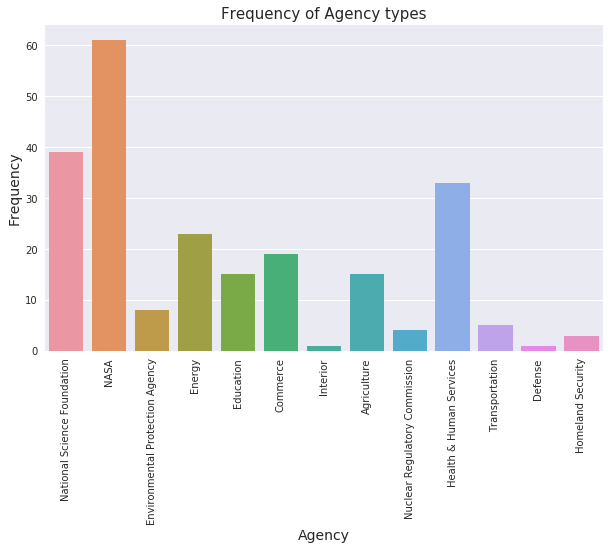

In [54]:
sns.set(style="darkgrid")

fig = plt.figure(figsize=(10,6))
sns.countplot(x="Agency", data = df)
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Agency', fontsize=14)
plt.xticks(rotation='vertical')
plt.title("Frequency of Agency types", fontsize=15)
plt.show()

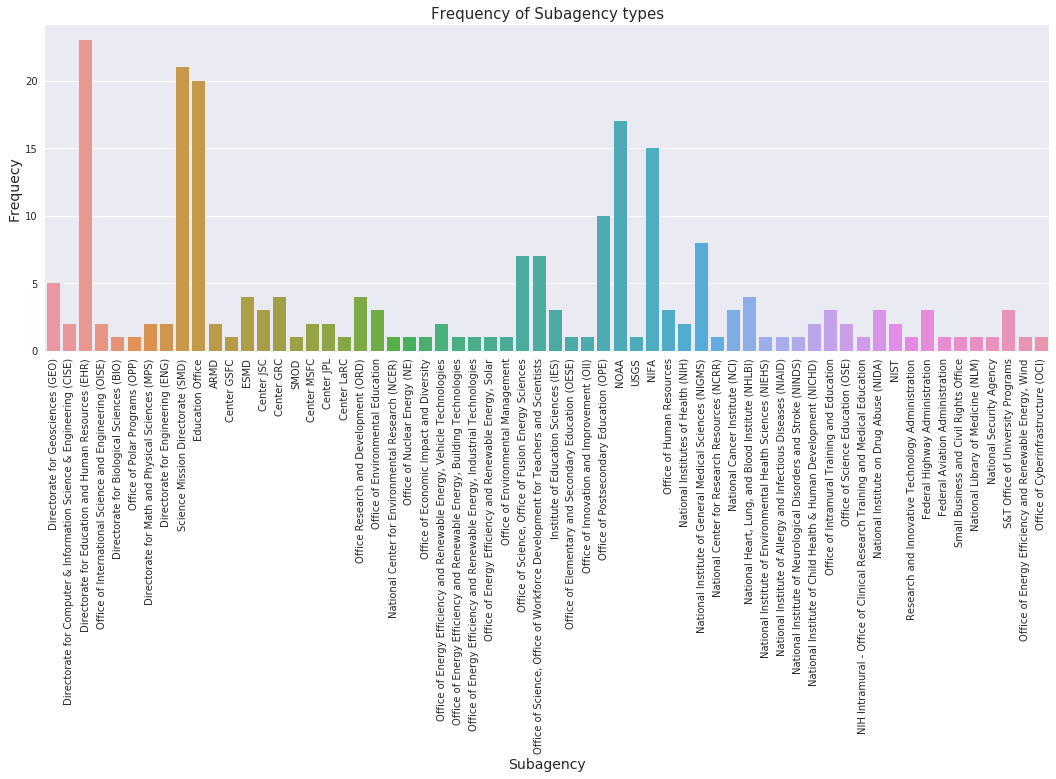

In [55]:
fig = plt.figure(figsize=(18,6))
sns.countplot(x="Subagency", data = df)
plt.ylabel('Frequecy', fontsize=14)
plt.xlabel('Subagency', fontsize=14)
plt.xticks(rotation='vertical')
plt.title("Frequency of Subagency types", fontsize=15)
plt.show()

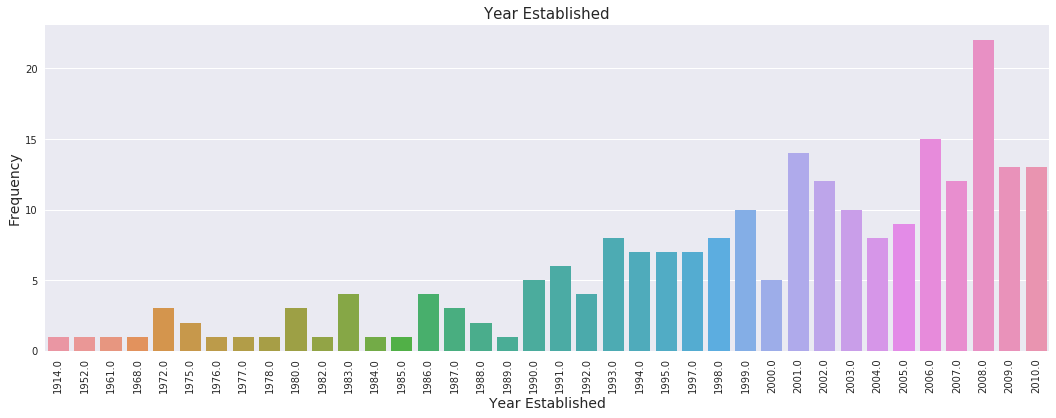

In [56]:
fig = plt.figure(figsize=(18,6))
sns.countplot(x="YE", data = df)
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Year Established', fontsize=14)
plt.xticks(rotation='vertical')
plt.title("Year Established", fontsize=15)
plt.show()

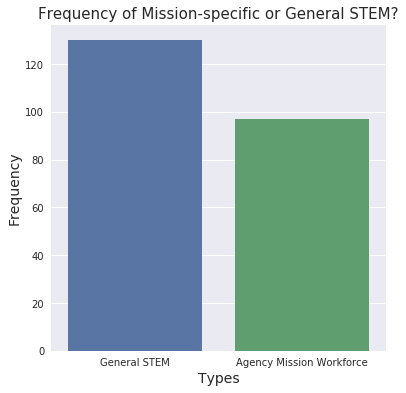

In [57]:
fig = plt.figure(figsize=(6,6))
sns.countplot(x="MGSTEM", data = df)
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Types', fontsize=14)
plt.title("Frequency of Mission-specific or General STEM?", fontsize=15)
plt.show()

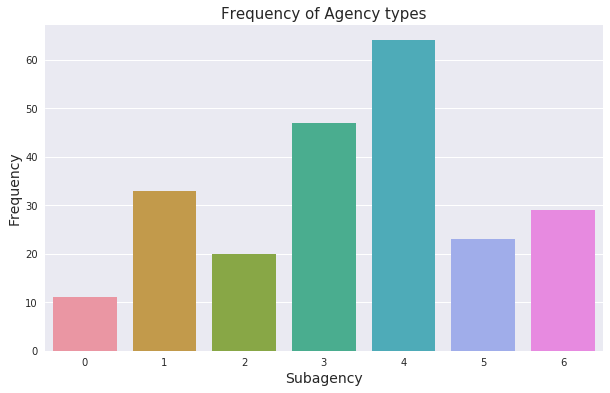

In [83]:
fig = plt.figure(figsize=(10,6))
sns.countplot(x="F1) Primary Investment Objective", data = df)
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Subagency', fontsize=14)
plt.title("Frequency of Agency types", fontsize=15)
plt.show()

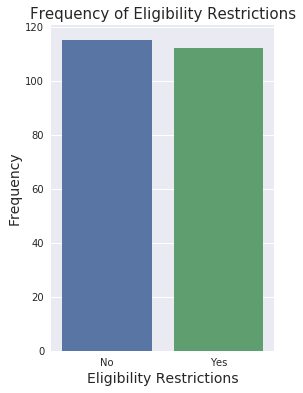

In [59]:
fig = plt.figure(figsize=(4,6))
sns.countplot(x="K) Eligibility Restrictions", data = df)
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Eligibility Restrictions', fontsize=14)
plt.title("Frequency of Eligibility Restrictions", fontsize=15)
plt.show()

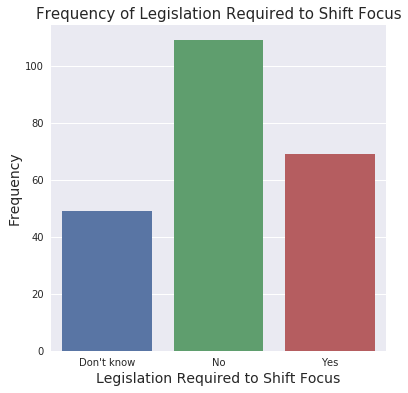

In [60]:
fig = plt.figure(figsize=(6,6))
sns.countplot(x="Q) Legislation Required to Shift Focus?", data = df)
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Legislation Required to Shift Focus', fontsize=14)
plt.title("Frequency of Legislation Required to Shift Focus", fontsize=15)
plt.show()

In [61]:

funding_cols = ['FY2008','FY2009','FY2010']
df_new = df.drop(funding_cols,axis=1)
non_funding_variable=df_new.iloc[:,:8]
nonfunding_columnlist = non_funding_variable.columns.tolist()
for column in nonfunding_columnlist:
        score = mutual_info_score(df['target'],df[column])
        print("Mutual info score of the target variable and the",column," is :",score)


Mutual info score of the target variable and the Agency  is : 0.0704363668423
Mutual info score of the target variable and the Subagency  is : 0.21529247569
Mutual info score of the target variable and the YE  is : 0.0961431550341
Mutual info score of the target variable and the MGSTEM  is : 0.00198609070432
Mutual info score of the target variable and the F1) Primary Investment Objective  is : 0.0296452692204
Mutual info score of the target variable and the J) Focus on Underrepresented Groups in STEM  is : 0.00794678679798
Mutual info score of the target variable and the K) Eligibility Restrictions  is : 0.000460650567218
Mutual info score of the target variable and the Q) Legislation Required to Shift Focus?  is : 0.0351587046636


## STAGE 3:
#1) Divide data into train & test samples. (70-30 split)
#2) Select features & build xgboost model. You will be judged on roc_auc_score on test sample.

In [69]:
def econding_cat_feature():
    lebelencoder = LabelEncoder()
    for column in df_new.columns:
        df_new[column]=lebelencoder.fit_transform(df_new[column])
    return df_new

In [70]:
#econding the categorical features of the dataframe
df_new = econding_cat_feature()


In [71]:
#task 1 of the stage 3
x = df_new.drop('target' ,axis=1)
y = df_new['target']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [80]:
from xgboost import XGBClassifier
clf = XGBClassifier(max_depth=7, n_estimators=300, learning_rate=0.05,min_child_weight=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [81]:
from sklearn.metrics import roc_auc_score
print("ROC Score : " + '{}'.format(roc_auc_score(y_test, y_pred)))

ROC Score : 0.6819444444444445


In [82]:
from sklearn.metrics import accuracy_score
ac =accuracy_score(y_test,y_pred)
ac

0.72463768115942029